In [1]:
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [5]:
%matplotlib widget

In [6]:
save_dir = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\pictures and plots")

# Load single experiment

In [7]:
data_dir = Path(r"P:\\")
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\subject_metadata.csv")
all_subexp = pd.read_csv(subject_csv)
all_subexp.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance,tiparea,dist_CL,color
0,mouse771424,F,NaN,C57BL/6J,THstim_d1_2024-11-14_11-28-16,True,False,300,TH,0.925338,tomato
1,mouse771424,F,NaN,C57BL/6J,THstim_d2_2024-11-15_10-51-49,True,False,300,CP,1.494992,firebrick
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300,PAL,1.286954,limegreen
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300,int,1.435270,forestgreen
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100,AV,0.686477,violet


In [8]:
choose_sub = 7
exprow = all_subexp.iloc[choose_sub]
data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [10]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\THstim_project', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

THstim_d2


Get coords for stim electrode

In [11]:
stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
if os.path.exists(stim_elec_file):
    with open(stim_elec_file) as elec_file:
        stim_elec_data = json.load(elec_file)
else:
    print('Stim electrode location file not found.')

In [12]:
stim_elec_data

{'surface': {'area': 'RSPd1', 'ccf_coords': [270, 12, 204]},
 'tip': {'area': 'CL', 'ccf_coords': [263, 131, 198]}}

## Load other data

### Load stim log and simple log

In [13]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [14]:
simple_log_file = exp.stimulus_log_file[:exp.stimulus_log_file.find('estim_log')] + 'simple_' + exp.stimulus_log_file[exp.stimulus_log_file.find('estim_log'):]
if os.path.exists(simple_log_file):
    simple_log = pd.read_csv(simple_log_file)
elif os.path.exists(os.path.join(exp.data_folder, r'simple_estim_log.csv')):
    simple_log = pd.read_csv(os.path.join(exp.data_folder, r'simple_estim_log.csv'))
else:
    print('No simple log found')

In [15]:
simple_log.head()

,stim_type,parameter,duration,onset,offset,sweep
0,freq50Hz,10,20,1377.05180,1397.05193,0
1,freq50Hz,50,20,1488.10577,1508.10590,0
2,freq50Hz,50,40,1608.41940,1648.41965,0
3,freq50Hz,50,40,1748.36228,1788.36253,0
4,freq50Hz,100,40,1878.41344,1918.41369,0


### Load isoflurane signal

In [16]:
iso_level, isots = exp.load_analog_iso()
iso_induction, iso_maintenance = exp.load_iso_times()
iso_level = iso_level - np.mean(iso_level[isots < iso_induction[0]-5])

### Load pupil diameter, if it exists

In [17]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
  
    pupilts = pupildf.sync_time.values
    pupilR = pupildf.Largest_Radius.values
    ## smooth pupil diameter, then normalize ##
    sm_pupil = np.zeros_like(pupilR)
    k = 5 # filter window is actually k*2+1
    for i in range(k, len(pupilR)-k-1):
        sm_pupil[i] = np.mean(pupilR[i-k:i+k]) # each point is the average of k surrounding points
    sm_pupil[:k] = pupilR[:k]
    sm_pupil[-k-1:] = pupilR[-k-1:]
    pupil = sm_pupil / np.mean(pupildf.Eye_Diameter.values)
    print('{:d}% of frames do not have good pupil measurements'.format(int((np.sum(np.isnan(pupilR)) / len(pupilR)) * 100)))
else:
    print('No local Pupileye*.csv file. Check server.')

0% of frames do not have good pupil measurements


In [18]:
np.mean(pupildf.Eye_Diameter.values)

351.24527970968785

In [19]:
awake_pupil_mean = np.nanmean(sm_pupil[pupilts < iso_induction[0]])
awake_pupil_std = np.nanstd(sm_pupil[pupilts < iso_induction[0]])

### Load running

In [20]:
running_file = os.path.join(exp.data_folder, 'running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

Original plot

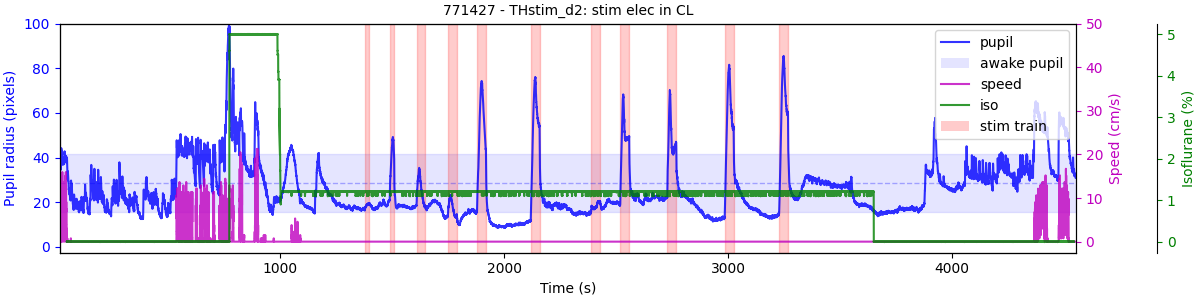

In [21]:
fig, ax = plt.subplots(figsize=(12,3), constrained_layout=True)
## Pupil ##
ax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.1)
ax.axhline(awake_pupil_mean, color='b', linewidth=1.0, linestyle='dashed', alpha=0.3)
pupat = mpatches.Rectangle((0, 0), 1, 1, fc='b', alpha=0.1, label='awake pupil')
pup, = ax.plot(pupilts, sm_pupil, color='b', alpha=0.8, label='pupil')
ax.set_xlim([pupilts[0], pupilts[-1]])
ax.set_ylim([-2.5, 100])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil radius (pixels)', color='b')
ax.tick_params(axis='y', colors='b')
## Add stim events ##
for ii, traini in simple_log.iterrows():
    ax.axvspan(traini.onset, traini.offset, color='r', alpha=0.2)
spat = mpatches.Rectangle((0, 0), 1, 1, fc='r', alpha=0.2, label='stim train')
## Running ##
runax = ax.twinx()
run, = runax.plot(speedts, speed, color='m', alpha=0.8, label='speed')
runax.set_ylabel('Speed (cm/s)', color='m')
runax.tick_params(axis='y', colors='m')
runax.set_ylim([-2.5, 50])
## Iso level ##
isoax = ax.twinx()
isoax.spines.right.set_position(("axes", 1.08))
isp, = isoax.plot(isots, iso_level, color='g', alpha=0.8, label='iso')
isoax.set_ylabel('Isoflurane (%)', color='g')
isoax.tick_params(axis='y', colors='g')
## Set title and legend ##
ax.set_title('{} - {}: stim elec in {}'.format(exp.mouse, exp_tag, stim_elec_data['tip']['area']))
ax.legend(handles = [pup, pupat, run, isp, spat], loc='upper right')

Plot for BSS

In [22]:
pupilcolor = 'navy'
runcolor = 'forestgreen'
isocolor = 'mediumvioletred'

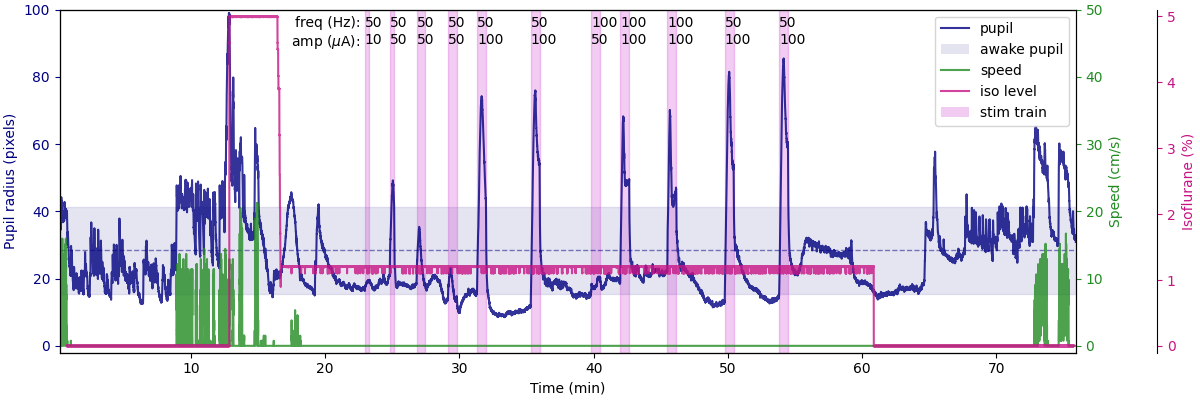

In [24]:
fig, ax = plt.subplots(figsize=(12,4), constrained_layout=True)

## Pupil ##
ax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color=pupilcolor, alpha=0.1)
ax.axhline(awake_pupil_mean, color=pupilcolor, linewidth=1.0, linestyle='dashed', alpha=0.5)
pupat = mpatches.Rectangle((0, 0), 1, 1, fc=pupilcolor, alpha=0.1, label='awake pupil')
pup, = ax.plot((pupilts)/60, sm_pupil, color=pupilcolor, alpha=0.8, label='pupil')
ax.set_xlim([pupilts[0]/60, pupilts[-1]/60])
ax.set_ylim([-2, 100])
ax.set_xlabel('Time (min)')
ax.set_ylabel('Pupil radius (pixels)', color=pupilcolor)
ax.tick_params(axis='y', colors=pupilcolor)

## Add stim events ##
for ii, traini in simple_log.iterrows():
    ax.axvspan(traini.onset/60, traini.offset/60, color='m', alpha=0.2)
    etag = traini.stim_type[4:-2] + '\n' + str(traini.parameter)
    ax.annotate(etag, xy=(traini.onset/60, 98), xycoords='data', va='top')
    if ii == 0:
        ax.annotate('freq (Hz):\namp ($\mu$A):', xy=((traini.onset-20)/60, 98), xycoords='data', va='top', ha='right')
spat = mpatches.Rectangle((0, 0), 1, 1, fc='m', alpha=0.2, label='stim train')


## Running ##
runax = ax.twinx()
run, = runax.plot(speedts/60, speed, color=runcolor, alpha=0.8, label='speed')
runax.set_ylabel('Speed (cm/s)', color=runcolor)
runax.tick_params(axis='y', colors=runcolor)
runax.set_ylim([-1, 50])

## Iso level ##
isoax = ax.twinx()
isoax.spines.right.set_position(("axes", 1.08))
isp, = isoax.plot(isots/60, iso_level, color=isocolor, alpha=0.8, label='iso level')
isoax.set_ylabel('Isoflurane (%)', color=isocolor)
isoax.tick_params(axis='y', colors=isocolor)
isoax.set_ylim([-0.1, 5.1])

## Set title and legend ##
# ax.set_title('{} - {}: stim elec in {}'.format(exp.mouse, exp_tag, stim_elec_data['tip']['area']))
ax.legend(handles = [pup, pupat, run, isp, spat], loc='upper right')

## Save the figure ##
fig_name = '{}_expsumm_totalmin.png'.format(exp_tag)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

DO windows

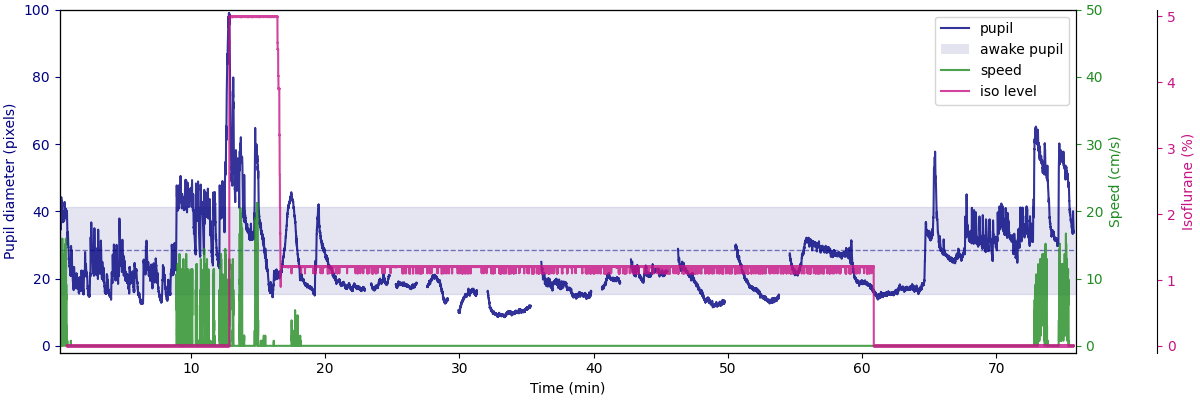

In [31]:
fig, ax = plt.subplots(figsize=(12,4), constrained_layout=True)
dwin = [0, isots[-1]]

## Pupil ##
ax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color=pupilcolor, alpha=0.1)
ax.axhline(awake_pupil_mean, color=pupilcolor, linewidth=1.0, linestyle='dashed', alpha=0.5)
pupat = mpatches.Rectangle((0, 0), 1, 1, fc=pupilcolor, alpha=0.1, label='awake pupil')
# pupinds = np.nonzero((pupilts >= dwin[0]) & (pupilts <= dwin[1]))
# pup, = ax.plot((pupilts[pupinds])/60, sm_pupil[pupinds], color=pupilcolor, alpha=0.8, label='pupil')
ax.set_xlim([pupilts[0]/60, pupilts[-1]/60])
ax.set_ylim([-2, 100])
ax.set_xlabel('Time (min)')
ax.set_ylabel('Pupil radius (pixels)', color=pupilcolor)
ax.tick_params(axis='y', colors=pupilcolor)

pupinds = np.nonzero((pupilts >= dwin[0]) & (pupilts <= simple_log.onset.values[0]))
pup, = ax.plot((pupilts[pupinds])/60, sm_pupil[pupinds], color=pupilcolor, alpha=0.8, label='pupil')
for ii in range(len(simple_log)-1):
    pupinds = np.nonzero((pupilts >= simple_log.offset.values[ii]+8) & (pupilts <= simple_log.onset.values[ii+1]))
    ax.plot((pupilts[pupinds])/60, sm_pupil[pupinds], color=pupilcolor, alpha=0.8)
pupinds = np.nonzero((pupilts >= simple_log.offset.values[-1]+8) & (pupilts <= dwin[1]))
ax.plot((pupilts[pupinds])/60, sm_pupil[pupinds], color=pupilcolor, alpha=0.8)


## Add stim events ##
# for ii, traini in simple_log.iterrows():
    # ax.axvspan(traini.onset/60, traini.offset/60, color='m', alpha=0.2)
    # etag = traini.stim_type[4:-2] + '\n' + str(traini.parameter)
    # ax.annotate(etag, xy=(traini.onset/60, 98), xycoords='data', va='top')
    # if ii == 0:
    #     ax.annotate('freq (Hz):\namp ($\mu$A):', xy=((traini.onset-20)/60, 98), xycoords='data', va='top', ha='right')
# spat = mpatches.Rectangle((0, 0), 1, 1, fc='m', alpha=0.2, label='stim train')


## Running ##
runax = ax.twinx()
runinds = np.nonzero((speedts >= dwin[0]) & (speedts <= dwin[1]))
run, = runax.plot(speedts[runinds]/60, speed[runinds], color=runcolor, alpha=0.8, label='speed')
runax.set_ylabel('Speed (cm/s)', color=runcolor)
runax.tick_params(axis='y', colors=runcolor)
runax.set_ylim([-1, 50])

## Iso level ##
isoax = ax.twinx()
isoax.spines.right.set_position(("axes", 1.08))
isoinds = np.nonzero((isots >= dwin[0]) & (isots <= dwin[1]))
isp, = isoax.plot(isots[isoinds]/60, iso_level[isoinds], color=isocolor, alpha=0.8, label='iso level')
isoax.set_ylabel('Isoflurane (%)', color=isocolor)
isoax.tick_params(axis='y', colors=isocolor)
isoax.set_ylim([-0.1, 5.1])

## Set title and legend ##
# ax.set_title('{} - {}: stim elec in {}'.format(exp.mouse, exp_tag, stim_elec_data['tip']['area']))
# ax.legend(handles = [pup, pupat, run, isp, spat], loc='upper right')
ax.legend(handles = [pup, pupat, run, isp], loc='upper right')

## Save the figure ##
fig_name = '{}_expsumm_isonostim.png'.format(exp_tag)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

# Load all subjects to loop through

In [25]:
all_subexp.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance,tiparea,dist_CL,color
0,mouse771424,F,NaN,C57BL/6J,THstim_d1_2024-11-14_11-28-16,True,False,300,TH,0.925338,tomato
1,mouse771424,F,NaN,C57BL/6J,THstim_d2_2024-11-15_10-51-49,True,False,300,CP,1.494992,firebrick
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300,PAL,1.286954,limegreen
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300,int,1.435270,forestgreen
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100,AV,0.686477,violet


Loop through each subject to make the plot

In [26]:
pupilcolor = 'navy'
runcolor = 'forestgreen'
isocolor = 'mediumvioletred'

mouse771424: THstim_d1
Experiment type: electrical stimulation
 44% of frames do not have good pupil measurements.

mouse771424: THstim_d2
Experiment type: electrical stimulation
 52% of frames do not have good pupil measurements.

mouse771425: THstim_d1
Experiment type: electrical stimulation
 0% of frames do not have good pupil measurements.

mouse771425: THstim_d2
Experiment type: electrical stimulation
 0% of frames do not have good pupil measurements.

mouse771426: THstim_d1
Experiment type: electrical stimulation
 0% of frames do not have good pupil measurements.

mouse771426: THstim_d2
Experiment type: electrical stimulation
 0% of frames do not have good pupil measurements.

mouse771427: THstim_d1
Experiment type: electrical stimulation
 0% of frames do not have good pupil measurements.

mouse771427: THstim_d2
Experiment type: electrical stimulation
 0% of frames do not have good pupil measurements.

mouse771427: THstim_d3
Experiment type: electrical and sensory stimulation
 0%

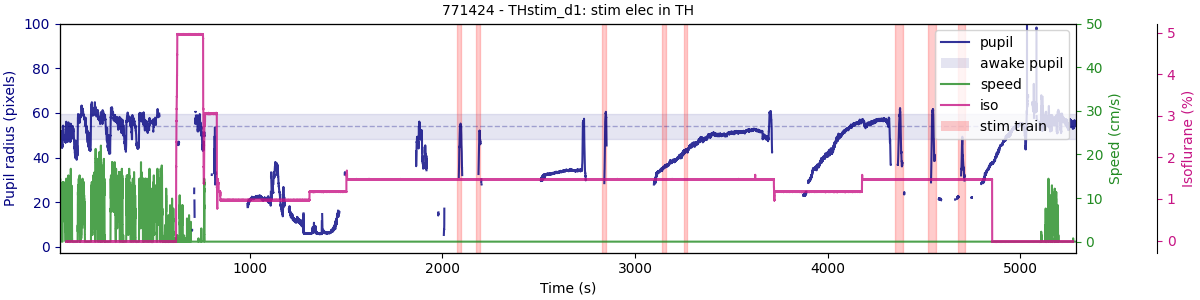

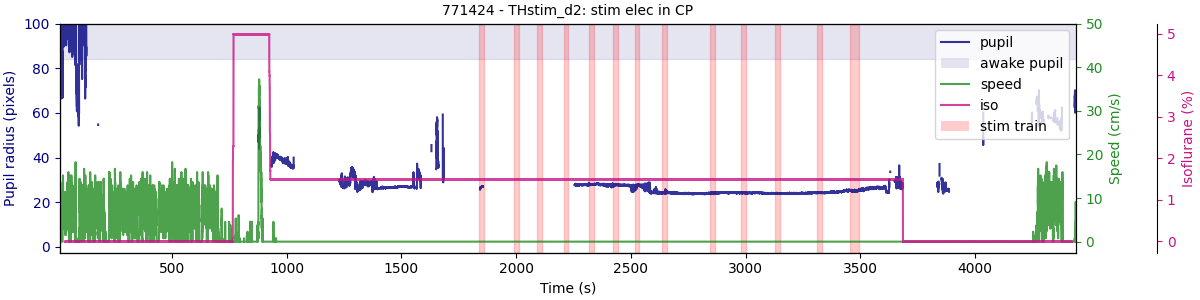

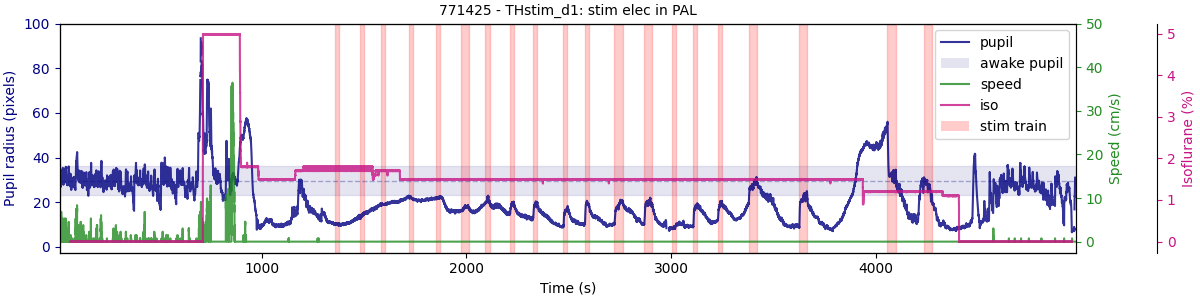

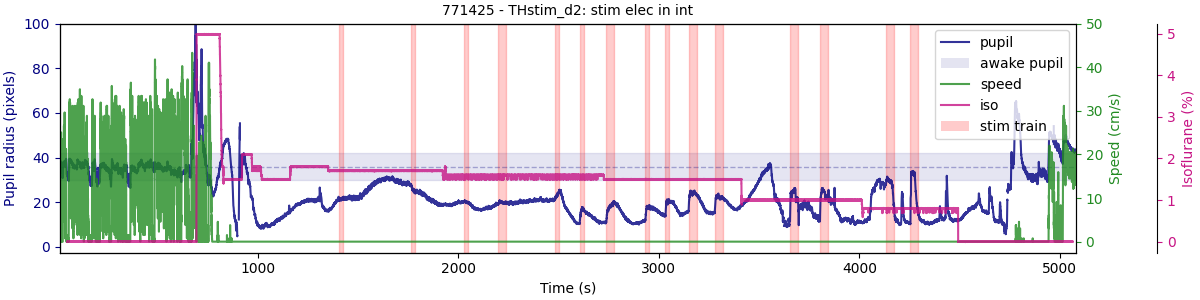

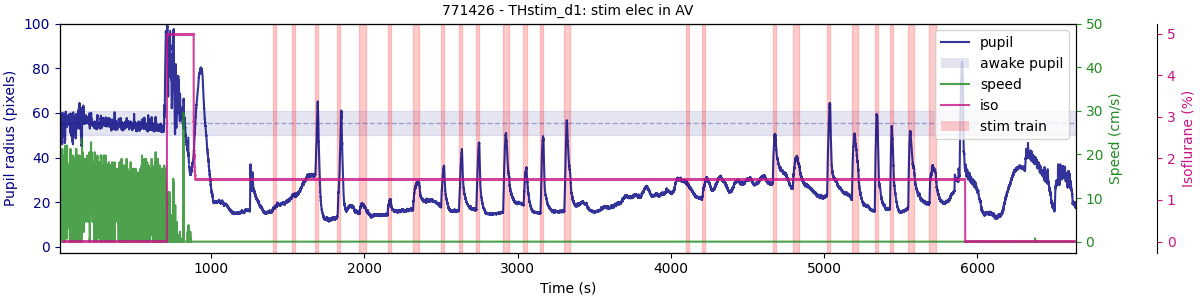

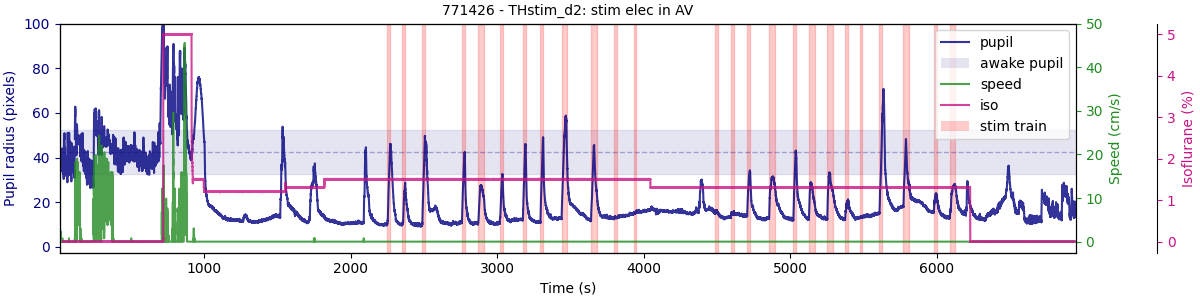

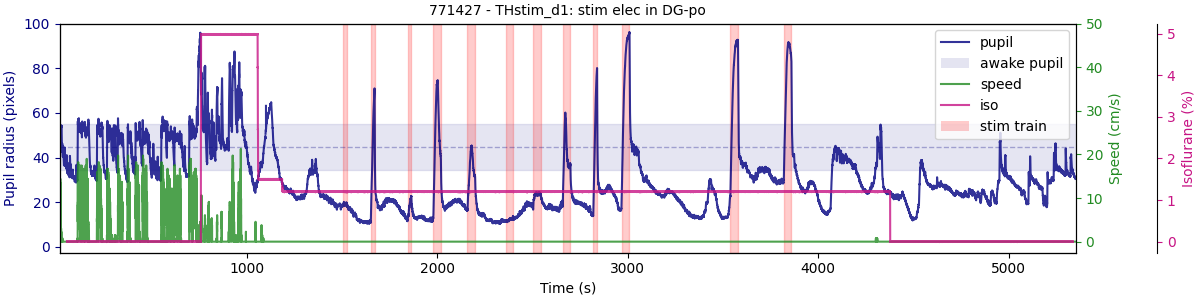

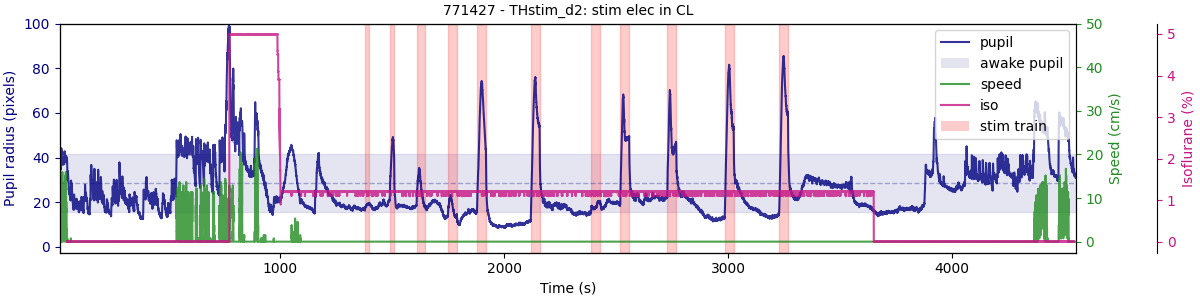

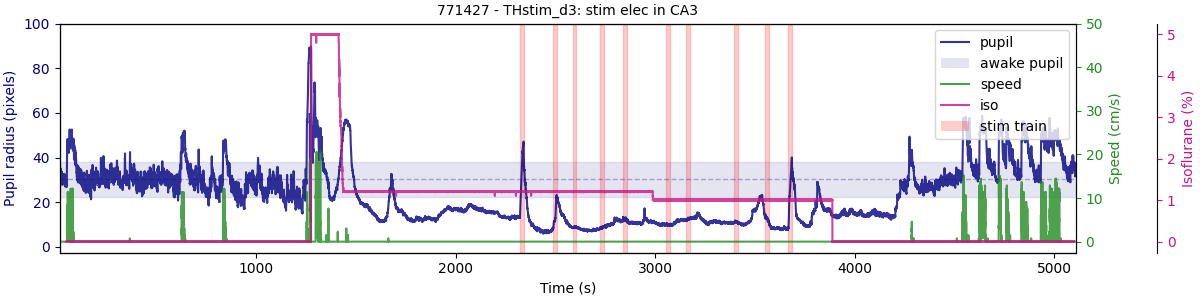

In [28]:
for indi, exprow in all_subexp.iterrows():
    exp_tag = exprow.exp_folder[:9]
    print('{}: {}'.format(exprow.mouse, exp_tag))
    
    data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
    exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)

    ## Get stim elec location ##
    stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
    if os.path.exists(stim_elec_file):
        with open(stim_elec_file) as elec_file:
            stim_elec_data = json.load(elec_file)
    else:
        print(' No stim electrode .json file.\n')
        continue

    ## Load the simple log ##
    simple_log_file = exp.stimulus_log_file[:exp.stimulus_log_file.find('estim_log')] + 'simple_' + exp.stimulus_log_file[exp.stimulus_log_file.find('estim_log'):]
    if os.path.exists(simple_log_file):
        simple_log = pd.read_csv(simple_log_file)
    elif os.path.exists(os.path.join(exp.data_folder, r'simple_estim_log.csv')):
        simple_log = pd.read_csv(os.path.join(exp.data_folder, r'simple_estim_log.csv'))
    else:
        print(' No simple stim log found.\n')
        continue

    ## Load the iso signal and times ##
    iso_level, isots = exp.load_analog_iso()
    iso_ind_on = isots[iso_level > 4.5][0]
    iso_level = iso_level - np.mean(iso_level[isots < iso_ind_on])
    
    ## Load the pupil file ##
    if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
        pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
        pupildf = pd.read_csv(pupil_file)
        pupilts = pupildf.sync_time.values
        pupilR = pupildf.Largest_Radius.values
        ## smooth pupil diameter, then normalize ##
        sm_pupil = np.zeros_like(pupilR)
        k = 5 # filter window is actually k*2+1
        for i in range(k, len(pupilR)-k-1):
            sm_pupil[i] = np.mean(pupilR[i-k:i+k]) # each point is the average of k surrounding points
        sm_pupil[:k] = pupilR[:k]
        sm_pupil[-k-1:] = pupilR[-k-1:]
        # pupil = sm_pupil / np.mean(pupildf.Eye_Diameter.values)
        print(' {:d}% of frames do not have good pupil measurements.'.format(int((np.sum(np.isnan(pupilR)) / len(pupilR)) * 100)))
        awake_pupil_mean = np.nanmean(sm_pupil[pupilts < iso_ind_on])
        awake_pupil_std = np.nanstd(sm_pupil[pupilts < iso_ind_on])
    else:
        print(' No local Pupileye*.csv file. Check server.\n')
        continue

    ## Load the running signal ##
    running_file = os.path.join(exp.data_folder, 'running_signal.npy')
    running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')
    if os.path.exists(running_file) and os.path.exists(running_ts_file):
        speed = np.load(running_file)
        speedts = np.load(running_ts_file)

    ## Create the summary plot ##
    fig, ax = plt.subplots(figsize=(12,3), constrained_layout=True)
    ## Pupil ##
    ax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color=pupilcolor, alpha=0.1)
    ax.axhline(awake_pupil_mean, color=pupilcolor, linewidth=1.0, linestyle='dashed', alpha=0.3)
    pupat = mpatches.Rectangle((0, 0), 1, 1, fc=pupilcolor, alpha=0.1, label='awake pupil')
    pup, = ax.plot(pupilts, sm_pupil, color=pupilcolor, alpha=0.8, label='pupil')
    ax.set_xlim([pupilts[0], pupilts[-1]])
    ax.set_ylim([-2.5, 100])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pupil radius (pixels)', color=pupilcolor)
    ax.tick_params(axis='y', colors=pupilcolor)
    ## Add stim events ##
    for ii, traini in simple_log.iterrows():
        ax.axvspan(traini.onset, traini.offset, color='r', alpha=0.2)
    spat = mpatches.Rectangle((0, 0), 1, 1, fc='r', alpha=0.2, label='stim train')
    ## Running ##
    runax = ax.twinx()
    run, = runax.plot(speedts, speed, color=runcolor, alpha=0.8, label='speed')
    runax.set_ylabel('Speed (cm/s)', color=runcolor)
    runax.tick_params(axis='y', colors=runcolor)
    runax.set_ylim([-2.5, 50])
    ## Iso level ##
    isoax = ax.twinx()
    isoax.spines.right.set_position(("axes", 1.08))
    isp, = isoax.plot(isots, iso_level, color=isocolor, alpha=0.8, label='iso')
    isoax.set_ylabel('Isoflurane (%)', color=isocolor)
    isoax.tick_params(axis='y', colors=isocolor)
    ## Set title and legend ##
    ax.set_title('{} - {}: stim elec in {}'.format(exp.mouse, exp_tag, stim_elec_data['tip']['area']))
    ax.legend(handles = [pup, pupat, run, isp, spat], loc='upper right')

    ## Save the figure ##
    fig_name = 'm{}{}_experimentsummary.png'.format(exp.mouse, exp_tag)
    fig.savefig(os.path.join(save_dir, fig_name), transparent=False) 

    print('')